In [5]:
# Código principal, proveniente de ML_28
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from google.cloud import bigquery
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

# Inicializar cliente BigQuery
client = bigquery.Client()

# Cargar datos desde BigQuery
query = "SELECT * FROM `pf-henry-404414.data_machine_learning.wb_data_machine_learning_bis`"
data_original = client.query(query).to_dataframe()
data = data_original.copy()

# Preprocesamiento: One-Hot Encoding para 'Pais'
data = pd.get_dummies(data, columns=['Pais'])

# Obtener la lista de todos los países únicos
all_countries = data_original['Pais'].unique()


# Lista de columnas numéricas (sin incluir la variable objetivo)
numeric_columns = [
    'Tasa_Natalidad', 'Emisiones_CO2', 'Educacion_obligatoria_en_anios',
    'gasto_salud_per_capita_ppp', 'Tasa_Mortalidad', 'Gasto_Salud_Gobierno',
    'gasto_salud_gobierno_per_capita_ppp', 'gasto_salud_privado_pct_gasto_salud_actual',
    'logro_educativo_secundaria_inferior_pct_poblacion_25_anios_mas', 'PIB_per_capita',
    'indice_gini', 'gasto_educacion_gobierno_pct_pib', 'Esperanza_vida_femenina',
    'Tasa_alfabetizacion_adultos', 'tasa_mortalidad_lesiones_trafico',
    'mortalidad_por___enfermedades_cardiovasculares_cancer_diabetes_enf_respiratorias_pct',
    'Mortalidad_adulta_femenina', 'Mortalidad_adulta_masculina', 'Mortalidad_infantil',
    'contaminacion_pct_poblacion_excede_oms', 'personas_saneamiento_basico_pct_poblacion',
    'Acceso_agua_potable', 'estabilidad_politica', 'brecha_pobreza_2_15_dolars_a_day',
    'prevalencia_desnutricion_pct_poblacion', 'Poblacion_rural', 'desempleo_total_ilo',
    'poblacion_urbana'
]

# Define la lista de indicadores excluyendo la variable objetivo y asegurándote de que no incluya columnas no numéricas
indicators = [col for col in numeric_columns if col != 'Esperanza_vida_total']


# Separar variables predictoras y objetivo
X = data[numeric_columns]
y = data['Esperanza_vida_total']

# Normalización de variables numéricas
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Aplicación de PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Entrenar y evaluar Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Entrenar y evaluar Perceptrón Multicapa (Red Neuronal)
nn = MLPRegressor(random_state=42)
nn.fit(X_train, y_train)
nn_pred = nn.predict(X_test)

# Entrenar y evaluar Regresión Lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Comparar métricas
print("Random Forest MSE:", mean_squared_error(y_test, rf_pred))
print("Random Forest R2:", r2_score(y_test, rf_pred))
print("Red Neuronal MSE:", mean_squared_error(y_test, nn_pred))
print("Red Neuronal R2:", r2_score(y_test, nn_pred))
print("Regresión Lineal MSE:", mean_squared_error(y_test, lr_pred))
print("Regresión Lineal R2:", r2_score(y_test, lr_pred))

# Validación cruzada y ajuste de hiperparámetros para Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Reentrenamiento con la mejor configuración
rf_optimized = RandomForestRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    random_state=42
)
rf_optimized.fit(X_train, y_train)

# Función para extrapolación de indicadores
def extrapolate_indicators(data, country, indicators, target_year):
    extrapolated_values = []
    for indicator in indicators:
        country_data = data[data['Pais'] == country]
        X = country_data['Anio'].values.reshape(-1, 1)
        y = country_data[indicator].values

        model = LinearRegression()
        model.fit(X, y)

        predicted_value = model.predict([[target_year]])[0]
        extrapolated_values.append(predicted_value)

    return np.array(extrapolated_values)

# Función para predecir esperanza de vida
def predict_life_expectancy(country, year, model, data_original, scaler, pca, indicators):
    extrapolated_values = extrapolate_indicators(data_original, country, indicators, year)

    # Aplicar las transformaciones a los valores extrapolados
    scaled_values = scaler.transform([extrapolated_values])
    pca_values = pca.transform(scaled_values)

    # Realizar la predicción
    predicted_life_expectancy = model.predict(pca_values)[0]
    return predicted_life_expectancy

# Código para realizar predicciones personalizadas
country_input = input("Ingrese el país deseado: ").title()
year_input = input("Ingrese el año deseado: ")

# Convertir el año de entrada a entero
try:
    year_input = int(year_input)
except ValueError:
    print("El año ingresado no es válido.")
    # Manejar adecuadamente la situación

# Asegurarse de que el país ingresado esté en la lista de países
if country_input not in all_countries:
    print("País no encontrado. Por favor, ingrese un país válido.")
    # Manejar adecuadamente la situación

# Llamar a la función con los argumentos correctos
predicted_life_expectancy = predict_life_expectancy(country_input, year_input, rf_optimized, data_original, scaler, pca, indicators)
print(f"La esperanza de vida del país {country_input} para el año {year_input} es: {predicted_life_expectancy}")

Random Forest MSE: 0.5303251167089678
Random Forest R2: 0.9606226069858075
Red Neuronal MSE: 2413.1394881568735
Red Neuronal R2: -178.17903382156325
Regresión Lineal MSE: 0.44343721792979296
Regresión Lineal R2: 0.9670741568570208
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Ingrese el país deseado: Ecuador
Ingrese el año deseado: 2040
La esperanza de vida del país Ecuador para el año 2040 es: 78.64324219560004


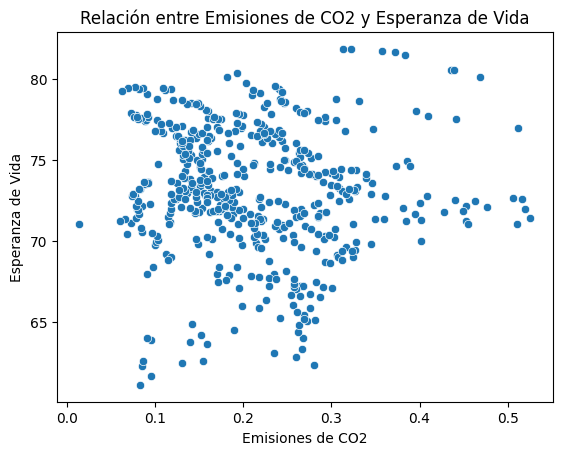

Coeficiente de Correlación entre ambos indicadores: -0.05130742772207967


In [14]:
# ¿Cuál es la relación entre las emisiones de CO2 y la esperanza de vida?

import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columns_of_interest = ['Emisiones_CO2', 'Esperanza_vida_total']
data_subset = data[columns_of_interest]

# Grafico de dispersión
sns.scatterplot(x='Emisiones_CO2', y='Esperanza_vida_total', data=data_subset)
plt.title('Relación entre Emisiones de CO2 y Esperanza de Vida')
plt.xlabel('Emisiones de CO2')
plt.ylabel('Esperanza de Vida')
plt.show()

# Calcular el coeficiente de correlación
correlation_coefficient = data_subset['Emisiones_CO2'].corr(data_subset['Esperanza_vida_total'])

# Imprimir el coeficiente de correlación
print(f"Coeficiente de Correlación entre ambos indicadores: {correlation_coefficient}")

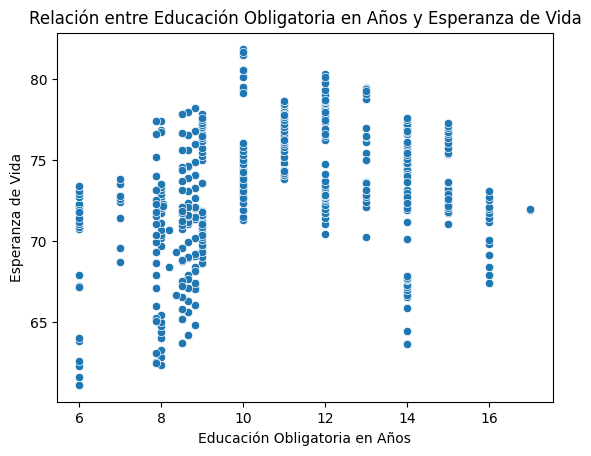

Coeficiente de Correlación entre ambos indicadores: 0.30370170797749196


In [15]:
 # ¿Cómo afecta el nivel de educación obligatoria en años a la esperanza de vida?

import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columns_of_interest = ['Educacion_obligatoria_en_anios', 'Esperanza_vida_total']
data_subset = data[columns_of_interest]

# Grafico de dispersión
sns.scatterplot(x='Educacion_obligatoria_en_anios', y='Esperanza_vida_total', data=data_subset)
plt.title('Relación entre Educación Obligatoria en Años y Esperanza de Vida')
plt.xlabel('Educación Obligatoria en Años')
plt.ylabel('Esperanza de Vida')
plt.show()

# Calcular el coeficiente de correlación
correlation_coefficient = data_subset['Educacion_obligatoria_en_anios'].corr(data_subset['Esperanza_vida_total'])

# Imprimir el coeficiente de correlación
print(f"Coeficiente de Correlación entre ambos indicadores: {correlation_coefficient}")





In [20]:
#¿Cuáles son los cinco países con la mayor esperanza de vida en 2040?

# Obtener la lista de todos los países únicos
all_countries = data_original['Pais'].unique()

# Diccionario para almacenar las predicciones de esperanza de vida para cada país en 2040
predictions_2040 = {}

# Iterar sobre todos los países y obtener las predicciones
for country in all_countries:
    predicted_life_expectancy = predict_life_expectancy(country, 2040, rf_optimized, data_original, scaler, pca, indicators)
    predictions_2040[country] = predicted_life_expectancy

# Ordenar los países por su esperanza de vida predicha en 2040 de mayor a menor
top_countries_2040 = sorted(predictions_2040.items(), key=lambda x: x[1], reverse=True)

# Imprimir los cinco países con la mayor esperanza de vida en 2040
print("Los cinco países con la mayor esperanza de vida en 2040 son:")
for i in range(5):
    print(f"{i+1}. {top_countries_2040[i][0]}: {top_countries_2040[i][1]} años")


Los cinco países con la mayor esperanza de vida en 2040 son:
1. Canada: 81.29183414770006 años
2. Colombia: 79.76949146400003 años
3. United States: 79.34228756160002 años
4. Panama: 79.13489317110003 años
5. Peru: 78.94069487870003 años


TypeError: ignored

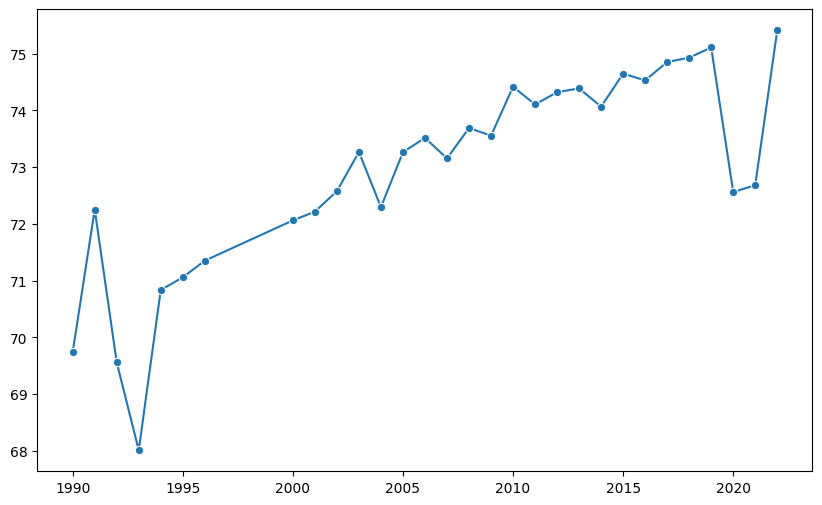

In [26]:
#Cómo ha cambiado la esperanza de vida global en las últimas dos décadas?

import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar las columnas relevantes para el análisis temporal
columns_of_interest = ['Anio', 'Esperanza_vida_total']
data_subset_temporal = data[columns_of_interest]

# Agrupar por año y calcular la esperanza de vida promedio
mean_life_expectancy_by_year = data_subset_temporal.groupby('Anio')['Esperanza_vida_total'].mean().reset_index()

# Graficar el cambio en la esperanza de vida a lo largo del tiempo
plt.figure(figsize=(10, 6))
sns.lineplot(x='Anio', y='Esperanza_vida_total', data=mean_life_expectancy_by_year, marker='o')
plt.title('Cambio en la Esperanza de Vida Global (Promedio) en las Últimas Dos Décadas')
plt.xlabel('Año')
plt.ylabel('Esperanza de Vida Promedio')
plt.grid(True)
plt.show()


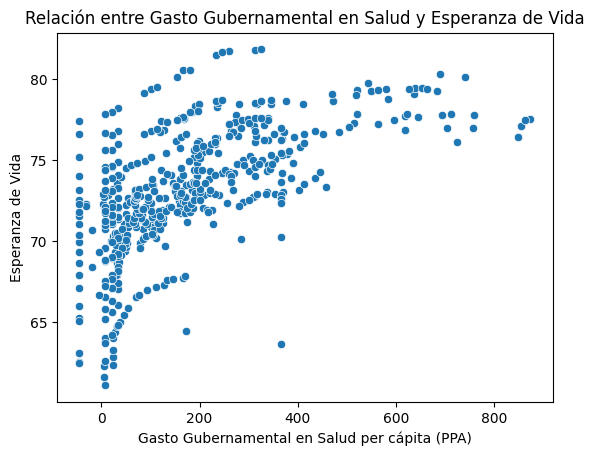

Coeficiente de Correlación entre ambos indicadores: 0.6098134892709538


In [28]:
#¿Cómo afecta el gasto gubernamental en salud al aumento de la esperanza de vida?

import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columns_of_interest = ['gasto_salud_gobierno_per_capita_ppp', 'Esperanza_vida_total']
data_subset = data[columns_of_interest]

# Eliminar filas con valores no finitos en las columnas de interés
data_subset = data_subset.dropna()

# Grafico de dispersión
sns.scatterplot(x='gasto_salud_gobierno_per_capita_ppp', y='Esperanza_vida_total', data=data_subset)
plt.title('Relación entre Gasto Gubernamental en Salud y Esperanza de Vida')
plt.xlabel('Gasto Gubernamental en Salud per cápita (PPA)')
plt.ylabel('Esperanza de Vida')
plt.show()

# Calcular el coeficiente de correlación
correlation_coefficient = data_subset['gasto_salud_gobierno_per_capita_ppp'].corr(data_subset['Esperanza_vida_total'])

# Imprimir el coeficiente de correlación
print(f"Coeficiente de Correlación entre ambos indicadores: {correlation_coefficient}")


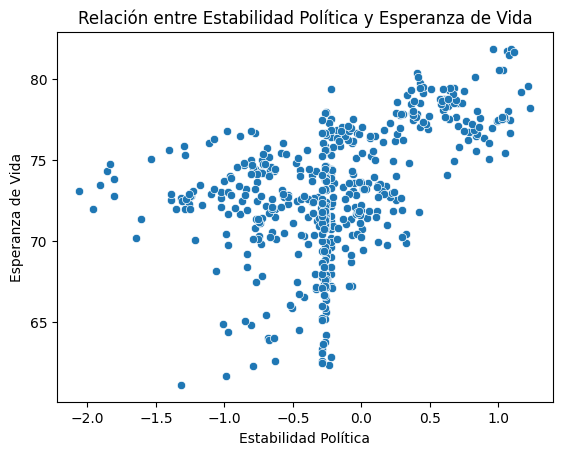

Coeficiente de Correlación entre ambos indicadores: 0.4657453040101854


In [30]:
##Existe una correlación entre la estabilidad política y la esperanza de vida?

import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columns_of_interest = ['estabilidad_politica', 'Esperanza_vida_total']
data_subset = data[columns_of_interest]

# Eliminar filas con valores no finitos en las columnas de interés
data_subset = data_subset.dropna()

# Grafico de dispersión
sns.scatterplot(x='estabilidad_politica', y='Esperanza_vida_total', data=data_subset)
plt.title('Relación entre Estabilidad Política y Esperanza de Vida')
plt.xlabel('Estabilidad Política')
plt.ylabel('Esperanza de Vida')
plt.show()

# Calcular el coeficiente de correlación
correlation_coefficient = data_subset['estabilidad_politica'].corr(data_subset['Esperanza_vida_total'])

# Imprimir el coeficiente de correlación
print(f"Coeficiente de Correlación entre ambos indicadores: {correlation_coefficient}")


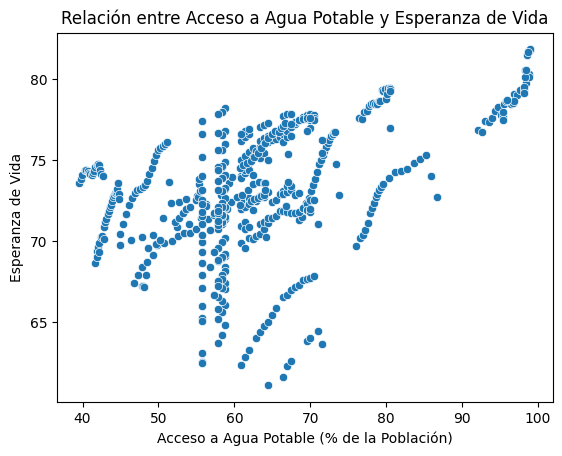

Coeficiente de Correlación entre ambos indicadores: 0.4785796174245539


In [36]:
#  Cuál es la relación entre el acceso al agua potable  y la esperanza de vida?
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columns_of_interest = ['Acceso_agua_potable', 'Esperanza_vida_total']
data_subset = data[columns_of_interest]

# Eliminar filas con valores no finitos en las columnas de interés
data_subset = data_subset.dropna()

# Grafico de dispersión
sns.scatterplot(x='Acceso_agua_potable', y='Esperanza_vida_total', data=data_subset)
plt.title('Relación entre Acceso a Agua Potable y Esperanza de Vida')
plt.xlabel('Acceso a Agua Potable (% de la Población)')
plt.ylabel('Esperanza de Vida')
plt.show()

# Calcular el coeficiente de correlación
correlation_coefficient = data_subset['Acceso_agua_potable'].corr(data_subset['Esperanza_vida_total'])

# Imprimir el coeficiente de correlación
print(f"Coeficiente de Correlación entre ambos indicadores: {correlation_coefficient}")


In [37]:
#¿Qué países tienen la esperanza de vida más baja en 2040?
# Año de interés
year_of_interest = 2040

# Diccionario para almacenar las predicciones de esperanza de vida para todos los países en 2040
predictions_2040 = {}

# Iterar sobre todos los países y obtener las predicciones
for country in all_countries:
    predicted_life_expectancy = predict_life_expectancy(country, year_of_interest, rf_optimized, data_original, scaler, pca, indicators)
    predictions_2040[country] = predicted_life_expectancy

# Ordenar las predicciones en orden ascendente
sorted_predictions = sorted(predictions_2040.items(), key=lambda x: x[1])

# Imprimir los países con la esperanza de vida más baja en 2040
print("Los cinco países con la esperanza de vida más baja en 2040 son:")
for country, life_expectancy in sorted_predictions[:5]:
    print(f"{country}: {life_expectancy} años")


Los cinco países con la esperanza de vida más baja en 2040 son:
Haiti: 64.26709662369998 años
Bolivia: 73.65160439049998 años
Guatemala: 75.35274341490003 años
Nicaragua: 76.64173853650001 años
Paraguay: 76.65684707319998 años


In [38]:
#¿Qué país tiene la esperanza de vida más alta para el 2040?
# Año de interés
year_of_interest = 2040

# Diccionario para almacenar las predicciones de esperanza de vida para todos los países en 2040
predictions_2040 = {}

# Iterar sobre todos los países y obtener las predicciones
for country in all_countries:
    predicted_life_expectancy = predict_life_expectancy(country, year_of_interest, rf_optimized, data_original, scaler, pca, indicators)
    predictions_2040[country] = predicted_life_expectancy

# Encontrar el país con la esperanza de vida más alta en 2040
country_with_highest_life_expectancy = max(predictions_2040, key=predictions_2040.get)
highest_life_expectancy = predictions_2040[country_with_highest_life_expectancy]

print(f"El país con la esperanza de vida más alta en {year_of_interest} es {country_with_highest_life_expectancy} con una esperanza de vida de {highest_life_expectancy} años.")


El país con la esperanza de vida más alta en 2040 es Canada con una esperanza de vida de 81.29183414770006 años.


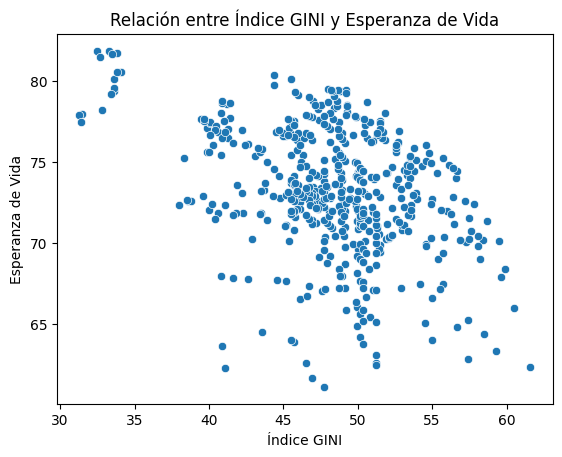

Coeficiente de Correlación entre ambos indicadores: -0.40241162556426735


In [40]:
# Cómo influye el índice GINI en la esperanza de vida?
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columns_of_interest = ['indice_gini', 'Esperanza_vida_total']
data_subset = data[columns_of_interest]

# Eliminar filas con valores no finitos en las columnas de interés
data_subset = data_subset.dropna()

# Grafico de dispersión
sns.scatterplot(x='indice_gini', y='Esperanza_vida_total', data=data_subset)
plt.title('Relación entre Índice GINI y Esperanza de Vida')
plt.xlabel('Índice GINI')
plt.ylabel('Esperanza de Vida')
plt.show()

# Calcular el coeficiente de correlación
correlation_coefficient = data_subset['indice_gini'].corr(data_subset['Esperanza_vida_total'])

# Imprimir el coeficiente de correlación
print(f"Coeficiente de Correlación entre ambos indicadores: {correlation_coefficient}")


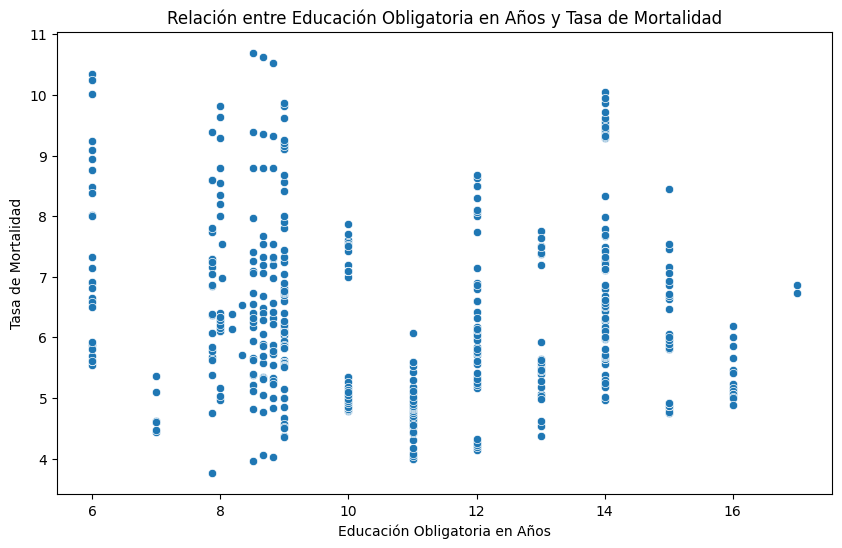

Coeficiente de Correlación entre ambos indicadores: -0.10500462894215798


In [45]:
# Cómo afecta el nivel de educación obligatoria en años a la tasa de mortalidad en un país?
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columns_of_interest = ['Educacion_obligatoria_en_anios', 'Tasa_Mortalidad']
data_subset_educacion_mortalidad = data[columns_of_interest]

# Eliminar filas con valores no finitos en las columnas de interés
data_subset_educacion_mortalidad = data_subset_educacion_mortalidad.dropna()

# Grafico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Educacion_obligatoria_en_anios', y='Tasa_Mortalidad', data=data_subset_educacion_mortalidad)
plt.title('Relación entre Educación Obligatoria en Años y Tasa de Mortalidad')
plt.xlabel('Educación Obligatoria en Años')
plt.ylabel('Tasa de Mortalidad')
plt.show()

# Calcular el coeficiente de correlación
correlation_coefficient = data_subset_educacion_mortalidad['Educacion_obligatoria_en_anios'].corr(data_subset_educacion_mortalidad['Tasa_Mortalidad'])

# Imprimir el coeficiente de correlación
print(f"Coeficiente de Correlación entre ambos indicadores: {correlation_coefficient}")



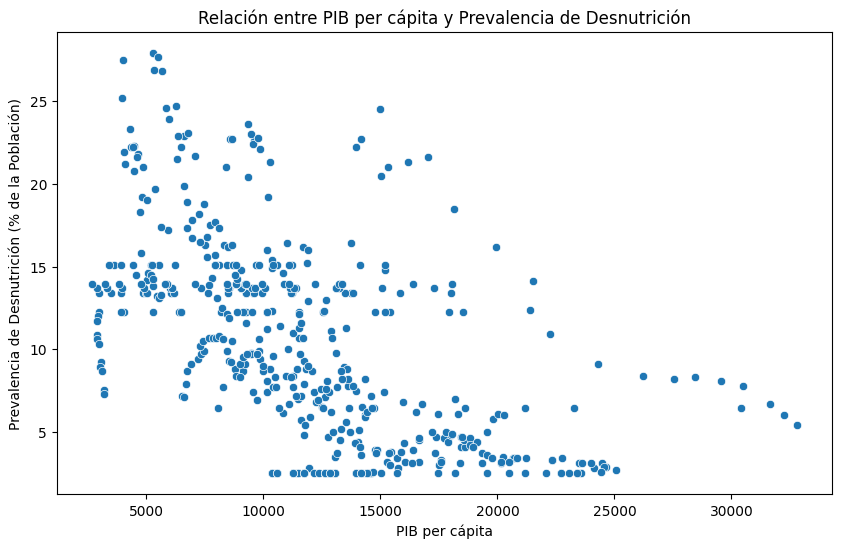

Coeficiente de Correlación entre ambos indicadores: -0.5709120155821643


In [48]:
# ¿Cómo afecta el PIB per cápita a la prevalencia de desnutrición en la población?
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columns_of_interest = ['PIB_per_capita', 'prevalencia_desnutricion_pct_poblacion']
data_subset_desnutricion = data[columns_of_interest]

# Eliminar filas con valores no finitos en las columnas de interés
data_subset_desnutricion = data_subset_desnutricion.dropna()

# Grafico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PIB_per_capita', y='prevalencia_desnutricion_pct_poblacion', data=data_subset_desnutricion)
plt.title('Relación entre PIB per cápita y Prevalencia de Desnutrición')
plt.xlabel('PIB per cápita')
plt.ylabel('Prevalencia de Desnutrición (% de la Población)')
plt.show()

# Calcular el coeficiente de correlación
correlation_coefficient = data_subset_desnutricion['PIB_per_capita'].corr(data_subset_desnutricion['prevalencia_desnutricion_pct_poblacion'])

# Imprimir el coeficiente de correlación
print(f"Coeficiente de Correlación entre ambos indicadores: {correlation_coefficient}")


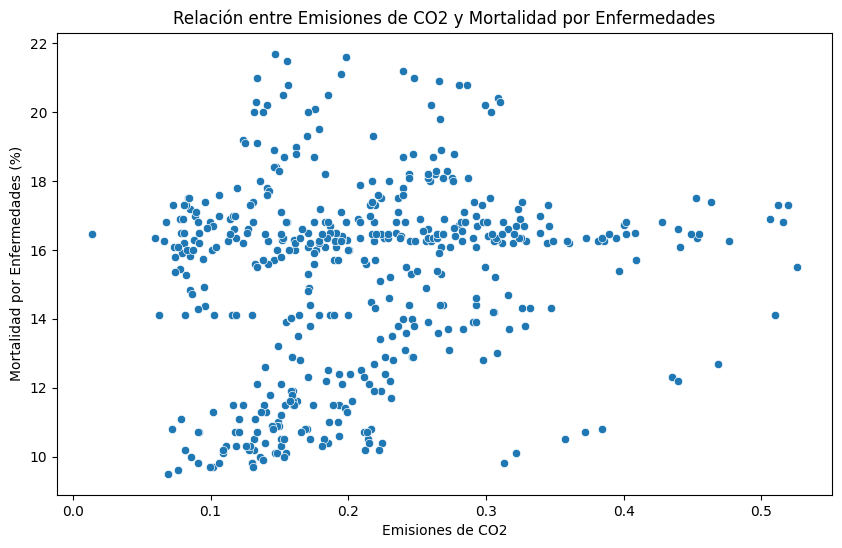

Coeficiente de Correlación entre ambos indicadores: 0.20082895918472396


In [50]:
# ¿Existe una relación entre las emisiones de CO2 y la tasa de mortalidad por
#enfermedades cardiovasculares, cáncer y diabetes?
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columns_of_interest = ['Emisiones_CO2', 'mortalidad_por___enfermedades_cardiovasculares_cancer_diabetes_enf_respiratorias_pct']
data_subset_mortalidad = data[columns_of_interest]

# Eliminar filas con valores no finitos en las columnas de interés
data_subset_mortalidad = data_subset_mortalidad.dropna()

# Grafico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Emisiones_CO2', y='mortalidad_por___enfermedades_cardiovasculares_cancer_diabetes_enf_respiratorias_pct', data=data_subset_mortalidad)
plt.title('Relación entre Emisiones de CO2 y Mortalidad por Enfermedades')
plt.xlabel('Emisiones de CO2')
plt.ylabel('Mortalidad por Enfermedades (%)')
plt.show()

# Calcular los coeficientes de correlación
correlation_coefficient = data_subset_mortalidad['Emisiones_CO2'].corr(data_subset_mortalidad['mortalidad_por___enfermedades_cardiovasculares_cancer_diabetes_enf_respiratorias_pct'])

# Imprimir el coeficiente de correlación
print(f"Coeficiente de Correlación entre ambos indicadores: {correlation_coefficient}")


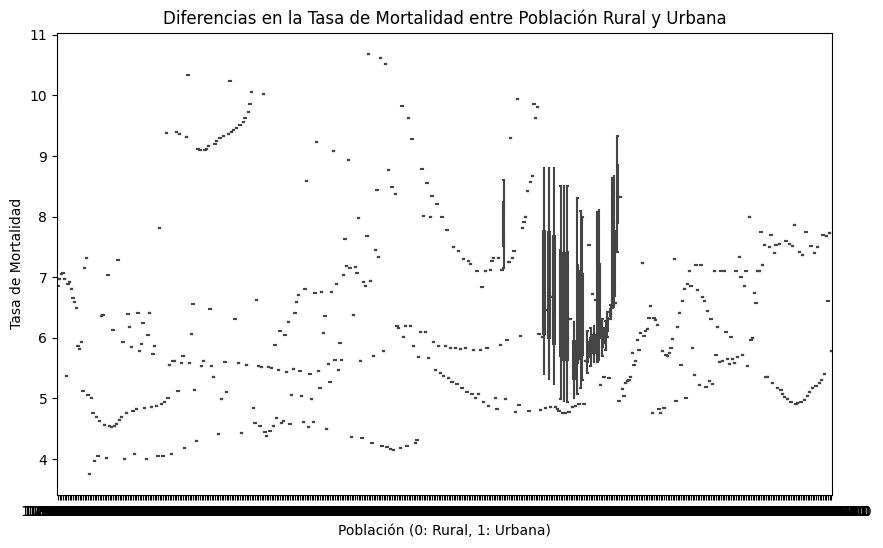

Test de t-student: Estadístico t = nan, Valor p = nan
No hay evidencia de diferencias significativas en la tasa de mortalidad entre población rural y urbana.


In [51]:
# ¿Hay diferencias significativas en la tasa de mortalidad entre la población rural y urbana?
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Seleccionar las columnas relevantes
columns_of_interest = ['poblacion_urbana', 'Tasa_Mortalidad']
data_subset_mortalidad_urbana = data[columns_of_interest]

# Eliminar filas con valores no finitos en las columnas de interés
data_subset_mortalidad_urbana = data_subset_mortalidad_urbana.dropna()

# Dividir los datos en población rural y urbana
rural_data = data_subset_mortalidad_urbana[data_subset_mortalidad_urbana['poblacion_urbana'] == 0]
urbana_data = data_subset_mortalidad_urbana[data_subset_mortalidad_urbana['poblacion_urbana'] == 1]

# Visualizar las diferencias con un gráfico de caja
plt.figure(figsize=(10, 6))
sns.boxplot(x='poblacion_urbana', y='Tasa_Mortalidad', data=data_subset_mortalidad_urbana)
plt.title('Diferencias en la Tasa de Mortalidad entre Población Rural y Urbana')
plt.xlabel('Población (0: Rural, 1: Urbana)')
plt.ylabel('Tasa de Mortalidad')
plt.show()

# Realizar un test de t-student para evaluar las diferencias significativas
t_statistic, p_value = stats.ttest_ind(rural_data['Tasa_Mortalidad'], urbana_data['Tasa_Mortalidad'])

# Imprimir el resultado del test
print(f"Test de t-student: Estadístico t = {t_statistic}, Valor p = {p_value}")

# Interpretar el resultado del test
if p_value < 0.05:
    print("Hay diferencias significativas en la tasa de mortalidad entre población rural y urbana.")
else:
    print("No hay evidencia de diferencias significativas en la tasa de mortalidad entre población rural y urbana.")


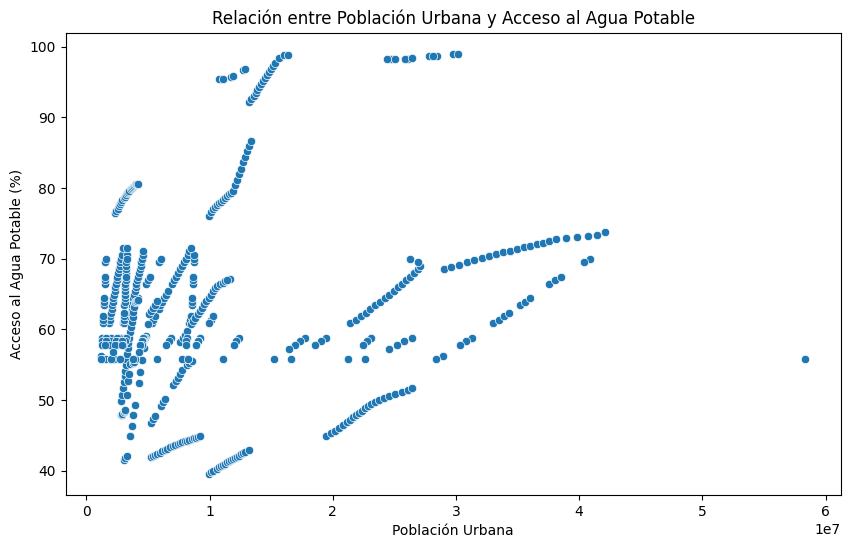

Coeficiente de Correlación entre ambos indicadores: 0.18582327136272375


In [53]:
# ¿Cómo afecta la población urbana al acceso al agua potable?
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columns_of_interest = ['poblacion_urbana', 'Acceso_agua_potable']
data_subset_agua_potable = data[columns_of_interest]

# Eliminar filas con valores no finitos en las columnas de interés
data_subset_agua_potable = data_subset_agua_potable.dropna()

# Grafico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='poblacion_urbana', y='Acceso_agua_potable', data=data_subset_agua_potable)
plt.title('Relación entre Población Urbana y Acceso al Agua Potable')
plt.xlabel('Población Urbana')
plt.ylabel('Acceso al Agua Potable (%)')
plt.show()

# Calcular el coeficiente de correlación
correlation_coefficient = data_subset_agua_potable['poblacion_urbana'].corr(data_subset_agua_potable['Acceso_agua_potable'])

# Imprimir el coeficiente de correlación
print(f"Coeficiente de Correlación entre ambos indicadores: {correlation_coefficient}")
